# Efficient sampling with Gaussian processes and Random Fourier Features

Gaussian processes (GPs) provide a mathematically elegant framework for learning unknown functions from data. They are robust to overfitting, allow to incorporate prior assumptions into the model and provide calibrated uncertainty estimates for their predictions. This makes them prime candidates in settings where data is scarce, noisy or very costly to obtain, and are natural tools in applications such as Bayesian optimisation (BO).

Despite their favorable properties, the use of GPs still has practical limitations. One of them is the computational complexity to draw predictive samples from the model, which quickly becomes prohibitive as the sample size grows, and creates a well-known bottleneck for GP-based Thompson sampling (GP-TS) for instance. 
Recent work <cite data-cite="wilson2020efficiently"/> proposes to combine GP’s weight-space and function-space views to draw samples more efficiently from (approximate) posterior GPs with encouraging results in low-dimensional regimes.

In GPflux, this functionality is unlocked by grouping a kernel (e.g., `gpflow.kernels.Matern52`) with its feature decomposition using `gpflux.sampling.KernelWithFeatureDecomposition`. See the notebooks on [weight space approximation](weight_space_approximation.ipynb) and [efficient posterior sampling](efficient_posterior_sampling.ipynb) for a thorough explanation.

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import gpflow
import gpflux

from gpflow.config import default_float

from gpflux.layers.basis_functions.fourier_features import RandomFourierFeaturesCosine
from gpflux.sampling import KernelWithFeatureDecomposition
from gpflux.models.deep_gp import sample_dgp

tf.keras.backend.set_floatx("float64")

2022-02-02 17:07:29.700930: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-02-02 17:07:29.700960: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load Snelson dataset

In [2]:
d = np.load("../../tests/snelson1d.npz")
X, Y = data = d["X"], d["Y"]
num_data, input_dim = X.shape

## Setting up the kernel and its feature decomposition

The `KernelWithFeatureDecomposition` instance represents a kernel together with its finite feature decomposition,
$$
k(x, x') = \sum_{i=0}^L \lambda_i \phi_i(x) \phi_i(x'),
$$
where $\lambda_i$ and $\phi_i(\cdot)$ are the coefficients (eigenvalues) and features (eigenfunctions), respectively, and $L$ is the finite cutoff. See [the notebook on weight space approximation](weight_space_approximation.ipynb) for a detailed explanation of how to construct this decomposition using Random Fourier Features (RFF).

In [3]:
kernel = gpflow.kernels.Matern52()
Z = np.linspace(X.min(), X.max(), 10).reshape(-1, 1).astype(np.float64)

inducing_variable = gpflow.inducing_variables.InducingPoints(Z)
gpflow.utilities.set_trainable(inducing_variable, False)

num_rff = 1000
eigenfunctions = RandomFourierFeaturesCosine(kernel, num_rff, dtype=default_float())
eigenvalues = np.ones((num_rff, 1), dtype=default_float())
kernel_with_features = KernelWithFeatureDecomposition(kernel, eigenfunctions, eigenvalues)

2022-02-02 17:07:31.840751: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hostedtoolcache/Python/3.7.12/x64/lib
2022-02-02 17:07:31.840779: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-02 17:07:31.840797: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (fv-az238-437): /proc/driver/nvidia/version does not exist
2022-02-02 17:07:31.841050: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-02 17:07:31.855123: W tensorflow/

## Building and training the single-layer GP

### Initialise the single-layer GP
Because `KernelWithFeatureDecomposition` is just a `gpflow.kernels.Kernel`, we can construct a GP layer with it.

In [4]:
layer = gpflux.layers.GPLayer(
    kernel_with_features,
    inducing_variable,
    num_data,
    whiten=True,
    num_latent_gps=1,
    mean_function=gpflow.mean_functions.Zero(),
)
likelihood_layer = gpflux.layers.LikelihoodLayer(gpflow.likelihoods.Gaussian())  # noqa: E231
dgp = gpflux.models.DeepGP([layer], likelihood_layer)
model = dgp.as_training_model()

/home/runner/work/GPflux/GPflux/gpflux/layers/gp_layer.py:199: UserWarning: Could not verify the compatibility of the `kernel`, `inducing_variable` and `mean_function`. We advise using `gpflux.helpers.construct_*` to create compatible kernels and inducing variables. As `num_latent_gps=1` has been specified explicitly, this will be used to create the `q_mu` and `q_sqrt` parameters.
  "Could not verify the compatibility of the `kernel`, `inducing_variable` "
/opt/hostedtoolcache/Python/3.7.12/x64/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated class TrackableLayer. (GPflux's `TrackableLayer` was prior to TF2.5 used to collect GPflow variables in subclassed layers. As of TF 2.5, `tf.Module` supports this natively and there is no need for `TrackableLayer` anymore. It will be removed in GPflux version `1.0.0`.)
  if __name__ == '__main__':


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


### Fit model to data

In [5]:
model.compile(tf.optimizers.Adam(learning_rate=0.1))

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="loss",
        patience=5,
        factor=0.95,
        verbose=0,
        min_lr=1e-6,
    )
]

history = model.fit(
    {"inputs": X, "targets": Y},
    batch_size=num_data,
    epochs=100,
    callbacks=callbacks,
    verbose=0,
)

2022-02-02 17:07:32.757101: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-02 17:07:32.757464: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2793435000 Hz


## Drawing samples

Now that the model is trained we can draw efficient and consistent samples from the posterior GP. By "consistent" we mean that the `sample_dgp` function returns a function object that can be evaluated multiple times at different locations, but importantly, the returned function values will come from the same GP sample. This functionality is implemented by the `gpflux.sampling.efficient_sample` function.

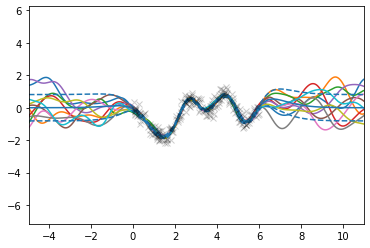

In [6]:
from typing import Callable

x_margin = 5
n_x = 1000
X_test = np.linspace(X.min() - x_margin, X.max() + x_margin, n_x).reshape(-1, 1)

f_mean, f_var = dgp.predict_f(X_test)
f_scale = np.sqrt(f_var)

# Plot samples
n_sim = 10
for _ in range(n_sim):
    # `sample_dgp` returns a callable - which we subsequently evaluate
    f_sample: Callable[[tf.Tensor], tf.Tensor] = sample_dgp(dgp)
    plt.plot(X_test, f_sample(X_test).numpy())

# Plot GP mean and uncertainty intervals and data
plt.plot(X_test, f_mean, "C0")
plt.plot(X_test, f_mean + f_scale, "C0--")
plt.plot(X_test, f_mean - f_scale, "C0--")
plt.plot(X, Y, "kx", alpha=0.2)
plt.xlim(X.min() - x_margin, X.max() + x_margin)
plt.ylim(Y.min() - x_margin, Y.max() + x_margin)
plt.show()